In [ ]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import plot_model

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.metrics import f1_score, classification_report, accuracy_score


import imaplib
import email
import yaml  # To load saved login credentials from a yaml file

from PIL import Image, ImageDraw, ImageFont
import textwrap
from IPython.display import display


In [ ]:
df_train = pd.read_csv('Email_train.csv', encoding='latin_1')

df_test = pd.read_csv('Email_test.csv', encoding='latin_1')

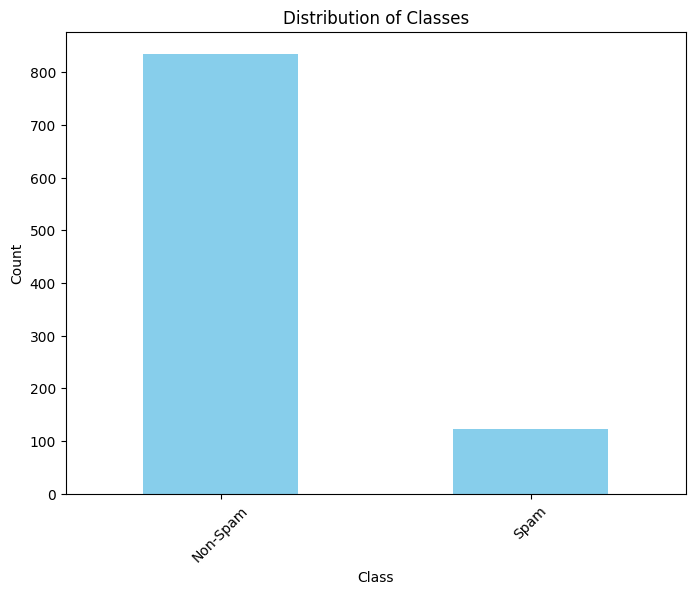

In [ ]:
plt.figure(figsize=(8, 6))
df_train['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_train.describe()

,S. No.
count,957.000000
mean,479.000000
std,276.406404
min,1.000000
25%,240.000000
50%,479.000000
75%,718.000000
max,957.000000


In [ ]:
df_test.describe()

,S. No.
count,125.000000
mean,63.000000
std,36.228442
min,1.000000
25%,32.000000
50%,63.000000
75%,94.000000
max,125.000000


In [ ]:
df_train

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam
...,...,...,...
952,953,hows my favourite person today? r u workin har...,Non-Spam
953,954,How much you got for cleaning,Non-Spam
954,955,Sorry da. I gone mad so many pending works wha...,Non-Spam
955,956,Wat time ü finish?,Non-Spam


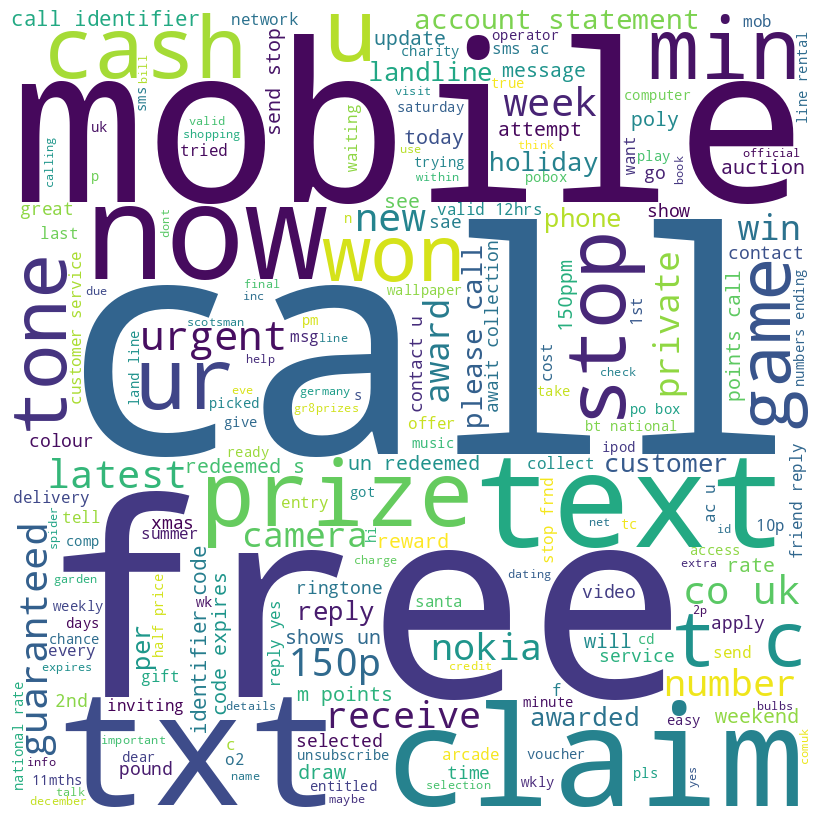

In [ ]:
df_visualize = df_train[df_train['Label'] == 'Spam']


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df_visualize['Message_body']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# count unique word
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text_values = df_train['Message_body']

counter = counter_word(text_values)
print(counter)

Counter({'to': 354, 'I': 246, 'you': 246, 'a': 218, 'the': 203, 'in': 136, 'is': 128, 'i': 125, 'u': 122, 'and': 116, 'for': 113, 'your': 105, 'my': 105, 'me': 91, 'of': 85, '2': 80, 'it': 77, 'call': 70, 'on': 70, 'have': 68, 'are': 66, 'will': 66, 'can': 64, 'or': 62, 'that': 62, 'be': 61, 'with': 60, 'at': 59, 'ur': 58, "I'm": 56, 'get': 54, '4': 54, 'so': 53, 'do': 50, 'from': 50, 'U': 46, 'if': 45, 'go': 45, 'was': 44, 'not': 44, '...': 41, 'but': 40, '&lt;#&gt;': 39, 'You': 39, 'we': 36, 'this': 36, 'up': 36, '.': 35, 'like': 34, 'know': 34, 'now': 34, 'Call': 34, 'got': 33, 'all': 33, 'just': 32, 'only': 31, 'come': 30, 'want': 30, '?': 30, 'out': 29, 'time': 28, 'its': 27, 'when': 27, 'If': 27, 'her': 27, 'he': 26, 'one': 26, 'A': 26, 'Just': 26, 'some': 25, 'then': 25, 'tell': 25, 'need': 25, 'see': 24, 'what': 24, 'still': 23, 'give': 23, 'has': 23, 'free': 22, 'We': 22, 'r': 22, 'our': 22, 'going': 21, 'And': 21, 'So': 21, 'back': 21, 'But': 21, 'Your': 21, 'mobile': 21, 'n'

In [ ]:
# Model parameter

vocab_size = len(counter)
embedding_dim = df_train['Message_body'].str.len().max()

max_length = 20

training_size = 765

In [ ]:
training_sentences = df_train['Message_body'][0:training_size]
training_labels = df_train['Label'][0:training_size]

val_sentences = df_train['Message_body'][training_size:]
val_labels = df_train['Label'][training_size:]

In [ ]:
training_labels = training_labels.replace(['Spam'], 1)
training_labels = training_labels.replace(['Non-Spam'], 0)

val_labels = val_labels.replace(['Spam'], 1)
val_labels = val_labels.replace(['Non-Spam'], 0)

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(training_sentences)

bigram_sentences = []
for sentence in training_sentences:
    words = text_to_word_sequence(sentence)
    bigrams = [f"{words[i]}_{words[i+1]}" for i in range(len(words) - 1)]
    bigram_sentence = " ".join(bigrams)
    bigram_sentences.append(bigram_sentence)

# Fit Tokenizer on the bigram sentences
tokenizer.fit_on_texts(bigram_sentences)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length)

In [ ]:
print(df_train['Message_body'][1])
print(training_sequences[1])

The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free
[6, 411, 132, 115, 1142, 37, 2, 1143, 56, 652, 38, 706, 8, 418, 249, 342, 159, 78, 10, 70, 529, 13, 3, 142, 11, 47]


In [ ]:
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

# LSTM

In [ ]:
lstm = Sequential()
lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
lstm.add(Bidirectional(LSTM(units=128)))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
lstm.build(input_shape=(None, max_length))


In [ ]:
lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 20, 446)             │       2,167,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         588,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,772,873 (10.58 MB)

 Trainable params: 2,772,873 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

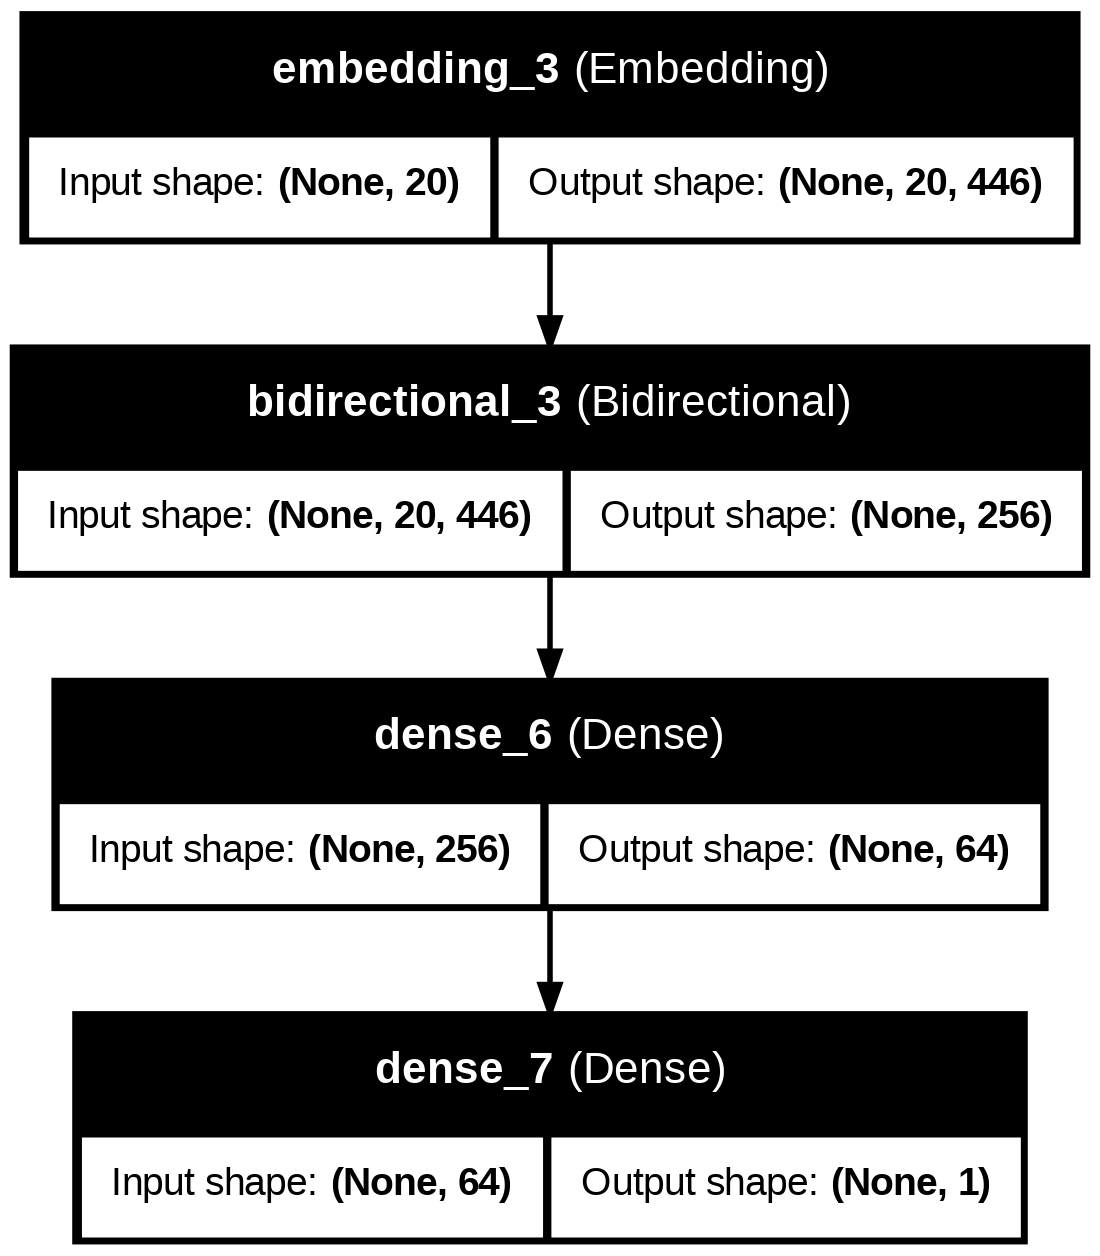

In [ ]:

plot_model(lstm, to_file='model_architecture_lstm.png', show_shapes=True, show_layer_names=True)

In [ ]:
# start training
epochs = 10
lstm_history = lstm.fit(training_padded, training_labels, epochs=epochs, validation_data=(val_padded, val_labels))

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 1.0000 - loss: 7.6686e-05 - val_accuracy: 0.9635 - val_loss: 0.1857
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 1.0000 - loss: 6.2879e-05 - val_accuracy: 0.9635 - val_loss: 0.1887
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.3758e-05 - val_accuracy: 0.9635 - val_loss: 0.1914
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 1.0000 - loss: 4.5233e-05 - val_accuracy: 0.9635 - val_loss: 0.1940
Epoch 5/50
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 1.0000 - loss: 3.8700e-05

KeyboardInterrupt: 

In [ ]:
lstm_loss = pd.DataFrame(lstm.history.history)
lstm_loss

,accuracy,loss,val_accuracy,val_loss
0,0.866667,0.302867,0.968750,0.138798
1,0.983007,0.087093,0.973958,0.097349
2,0.990850,0.030668,0.963542,0.141998
3,0.997386,0.012977,0.973958,0.127662
4,1.000000,0.001073,0.963542,0.157389
5,1.000000,0.000424,0.968750,0.165238
6,1.000000,0.000177,0.963542,0.169935
7,1.000000,0.000132,0.963542,0.174778
8,1.000000,0.000104,0.963542,0.178443
9,1.000000,0.000084,0.963542,0.182011


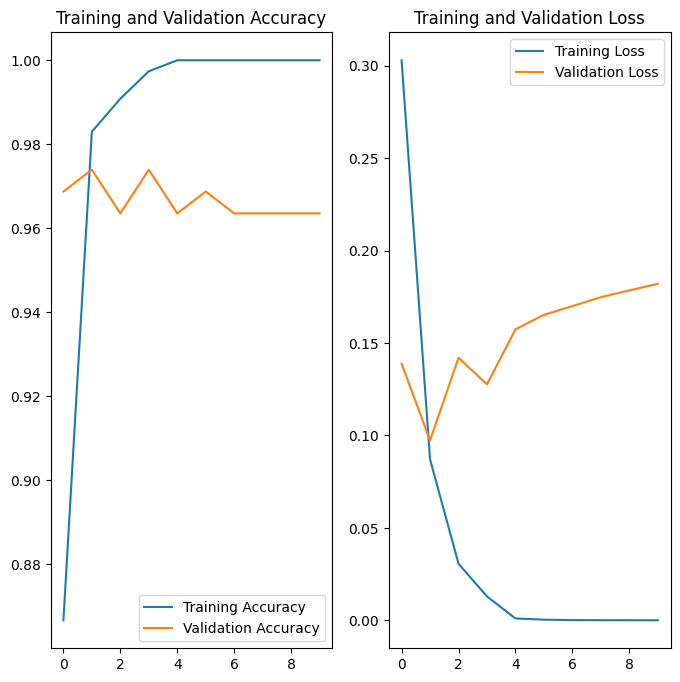

In [ ]:
acc = lstm_history.history['accuracy']
val_acc = lstm_history.history['val_accuracy']

loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
testing_sentences = df_test['Message_body']
testing_labels = df_test['Label']

testing_labels = testing_labels.replace(['Spam'], 1)
testing_labels = testing_labels.replace(['Non-Spam'], 0)

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [ ]:
lstm_predictions = lstm.predict(testing_padded)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


In [ ]:
testing_labels = pd.DataFrame(testing_labels)
testing_labels['Lstm_Prediction'] = lstm_predictions

<Axes: xlabel='Lstm_Prediction', ylabel='Count'>

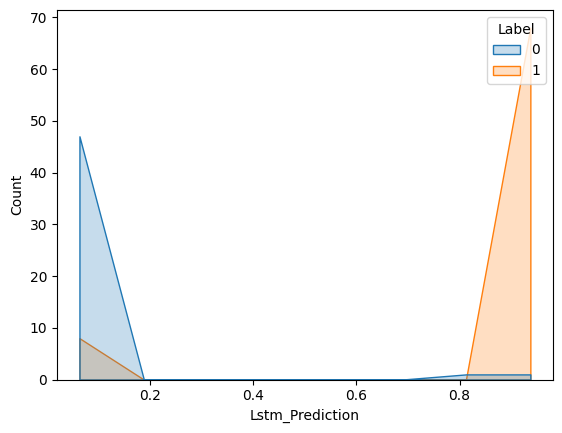

In [ ]:
sns.histplot(testing_labels, x='Lstm_Prediction', hue='Label', element='poly')

In [ ]:
# Scoring metric for prediction

testing_labels['Lstm_Prediction_labels'] = (testing_labels['Lstm_Prediction'] > 0.5).astype(int)

In [ ]:
LSTM_accuracy = accuracy_score(testing_labels['Label'], testing_labels['Lstm_Prediction_labels'])

print('LSTM Accuracy: {}'.format(LSTM_accuracy))
print(classification_report(testing_labels['Label'], testing_labels['Lstm_Prediction_labels']))

LSTM Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        49
           1       0.97      0.89      0.93        76

    accuracy                           0.92       125
   macro avg       0.91      0.93      0.92       125
weighted avg       0.93      0.92      0.92       125



<ipython-input-75-4861b54a265f>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
<ipython-input-75-4861b54a265f>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9591836734693877' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
<ipython-input-75-4861b54a265f>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.04081632653061224' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
<ipython-input-75-4861b54a265f>:7: FutureWarning: Series.__getitem__ treating ke

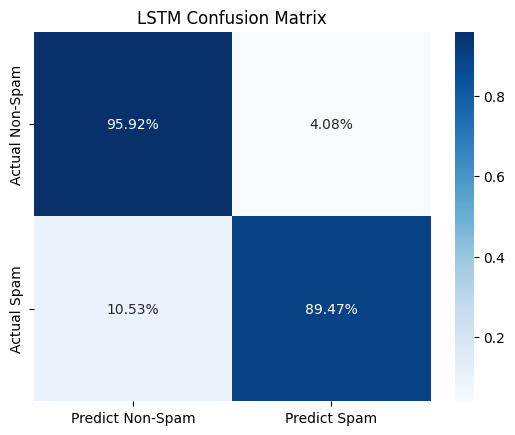

In [ ]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(testing_labels['Label'], testing_labels['Lstm_Prediction_labels']))
cm.columns = ['Predict Non-Spam', 'Predict Spam']
cm.index = ['Actual Non-Spam', 'Actual Spam']
cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
cm.iloc[1] = cm.iloc[1]/cm.sum(axis=1)[1]

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2%')
plt.title('LSTM Confusion Matrix')
plt.show()

In [ ]:

# Define the predict_email function
def preprocess_email(email, tokenizer, max_length):
    # Convert email to lowercase
    email = email.lower()
    # Convert email to sequences
    email_seq = tokenizer.texts_to_sequences([email])
    # Pad the sequence
    email_padded = pad_sequences(email_seq, maxlen=max_length)
    return email_padded

def predict_email(email, model, tokenizer, max_length):
    # Preprocess the email
    email_padded = preprocess_email(email, tokenizer, max_length)
    # Make prediction
    prediction = model.predict(email_padded)
    # Convert prediction to label
    label = 'Spam' if prediction > 0.5 else 'Non-Spam'
    return label

# Load credentials from the YAML file
with open("credentials.yml") as f:
    content = f.read()
my_credentials = yaml.load(content, Loader=yaml.FullLoader)
user, password = my_credentials["user"], my_credentials["password"]

# URL for IMAP connection
imap_url = 'imap.gmail.com'

# Connection with GMAIL using SSL
my_mail = imaplib.IMAP4_SSL(imap_url)

# Log in using your credentials
my_mail.login(user, password)

# Select the Inbox to fetch messages
my_mail.select('Inbox')

# Define Key and Value for email search
key = 'FROM'
value = input("Enter the email of the user whose mails you want to check: ")
_, data = my_mail.search(None, key, value)

mail_id_list = data[0].split()

msgs = []
email_bodies = []
for num in mail_id_list:
    typ, data = my_mail.fetch(num, '(RFC822)')
    msgs.append(data)

for msg in msgs[::-1]:
    for response_part in msg:
        if type(response_part) is tuple:
            my_msg = email.message_from_bytes(response_part[1])
            for part in my_msg.walk():
                if part.get_content_type() == 'text/plain':
                    email_body = part.get_payload()
                    email_bodies.append(email_body)




Enter the email of the user whose mails you want to check: khalidaperveen8656@gmail.com


In [ ]:

def create_prediction_image(email_body, predicted_label):
    # Define image dimensions and background color
    width, height = 500, 200
    background_color = 'white'
    text_color = 'black'

    # Create a blank image with white background
    image = Image.new('RGB', (width, height), background_color)
    draw = ImageDraw.Draw(image)

    # Define font and text size
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except IOError:
        font = ImageFont.load_default()

    # Wrap the email body text
    wrapped_email_body = textwrap.fill(email_body, width=70)

    # Prepare the text to be displayed
    text = f'The predicted label for the email stated:\n\n"{wrapped_email_body}"\n\nis:\n\n{predicted_label}'

    # Define text position
    margin = 20
    offset = 20

    for line in text.split('\n'):
        draw.text((margin, offset), line, font=font, fill=text_color)
        offset += 20

    # Display the image
    display(image)







1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


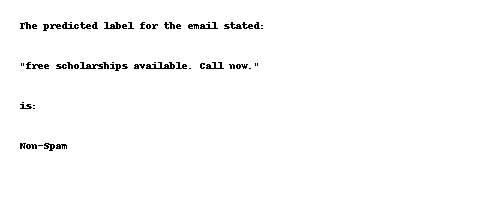

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


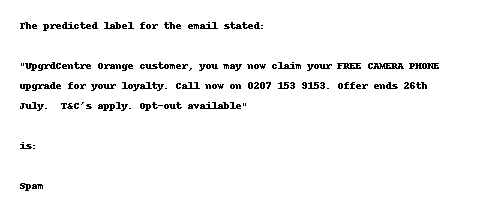

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


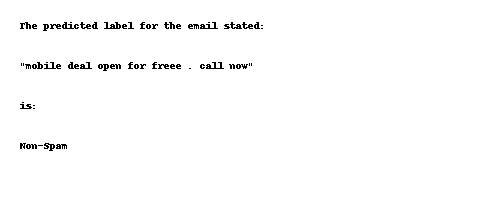

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


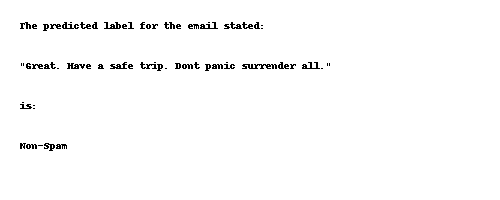

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


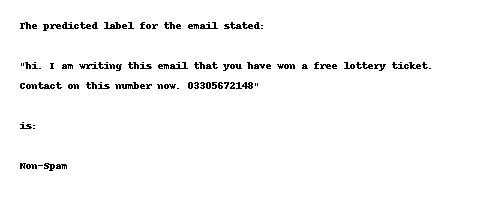

In [ ]:
# Apply prediction on each email body and store results
predictions = []
for email_body in email_bodies:
    predicted_label = predict_email(email_body, lstm, tokenizer, max_length)
    predictions.append(predicted_label)
    create_prediction_image(email_body, predicted_label)